In [9]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import fetch_kddcup99
%matplotlib inline

In [10]:
dataset = fetch_kddcup99(subset=None, shuffle=True, percent10=True)
# http://www.kdd.org/kdd-cup/view/kdd-cup-1999/Tasks
X = dataset.data
y = dataset.target

In [11]:
feature_cols = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serrer_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
X = pd.DataFrame(X, columns = feature_cols)

y = pd.Series(y)

In [12]:
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,b'icmp',b'ecr_i',b'SF',1032,0,0,0,0,0,...,255,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,b'icmp',b'ecr_i',b'SF',1032,0,0,0,0,0,...,255,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,b'icmp',b'ecr_i',b'SF',1032,0,0,0,0,0,...,255,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,b'icmp',b'ecr_i',b'SF',520,0,0,0,0,0,...,255,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,b'tcp',b'http',b'SF',293,253,0,0,0,0,...,175,255,1.0,0.0,0.01,0.02,0.0,0.0,0.0,0.0


In [13]:
for col in X.columns:  # turn whatever columns into floats that we can
    try:
        X[col] = X[col].astype(float)
    except ValueError:
        pass

In [14]:
X = pd.get_dummies(X, prefix=['protocol_type_', 'service_', 'flag_'], drop_first=True)

In [15]:
X.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag__b'REJ',flag__b'RSTO',flag__b'RSTOS0',flag__b'RSTR',flag__b'S0',flag__b'S1',flag__b'S2',flag__b'S3',flag__b'SF',flag__b'SH'
0,0.0,1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,293.0,253.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [16]:
y.value_counts()

b'smurf.'              280790
b'neptune.'            107201
b'normal.'              97278
b'back.'                 2203
b'satan.'                1589
b'ipsweep.'              1247
b'portsweep.'            1040
b'warezclient.'          1020
b'teardrop.'              979
b'pod.'                   264
b'nmap.'                  231
b'guess_passwd.'           53
b'buffer_overflow.'        30
b'land.'                   21
b'warezmaster.'            20
b'imap.'                   12
b'rootkit.'                10
b'loadmodule.'              9
b'ftp_write.'               8
b'multihop.'                7
b'phf.'                     4
b'perl.'                    3
b'spy.'                     2
dtype: int64

Será que o problema é a lista Y que tem texto e categorias em vez de números ?

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y)
print(le.classes_)
y_integer = le.transform(y)

[b'back.' b'buffer_overflow.' b'ftp_write.' b'guess_passwd.' b'imap.'
 b'ipsweep.' b'land.' b'loadmodule.' b'multihop.' b'neptune.' b'nmap.'
 b'normal.' b'perl.' b'phf.' b'pod.' b'portsweep.' b'rootkit.' b'satan.'
 b'smurf.' b'spy.' b'teardrop.' b'warezclient.' b'warezmaster.']


In [18]:
# fit a classification tree with max_depth=3 on all data
from sklearn.tree import DecisionTreeClassifier, export_graphviz

treeclf = DecisionTreeClassifier(max_depth=7)

scores = cross_val_score(treeclf, X, y_integer, scoring='accuracy', cv=5)

print(np.mean(scores))

treeclf.fit(X, y_integer)

/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


0.9955022154436215


DecisionTreeClassifier(max_depth=7)

In [19]:
# create a Graphviz file
export_graphviz(treeclf, out_file='tree_kdd.dot', feature_names=X.columns)

# At the command line, run this to convert to PNG:
!dot -Tpng tree_kdd.dot -o tree_kdd.png

/bin/bash: line 1: dot: command not found


<img src="https://github.com/nunoaflopes/IA4cyber-Livro2-Hands-on-ML-for-Cyber-Security-Packt/blob/master/Chapter07/tree_kdd.png?raw=1">

In [20]:
pd.DataFrame({'feature':X.columns, 'importance':treeclf.feature_importances_}).sort_values('importance', ascending=False).head(10)

,feature,importance
20,srv_count,0.613781
25,same_srv_rate,0.331015
9,num_compromised,0.013185
31,dst_host_diff_srv_rate,0.010631
33,dst_host_srv_diff_host_rate,0.006812
4,wrong_fragment,0.006600
35,dst_host_srv_serror_rate,0.006334
108,flag__b'RSTR',0.004781
1,src_bytes,0.003418
39,protocol_type__b'udp',0.000974


In [21]:
# How about a Random Forest?
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

scores = cross_val_score(rf, X, y_integer, scoring='accuracy', cv=5)

print(np.mean(scores))  # nicer

rf.fit(X, y_integer)

/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


0.9997813856968041


RandomForestClassifier()

In [22]:
# more spread out importances than a single decision tree
pd.DataFrame({'feature':X.columns, 'importance':rf.feature_importances_}).sort_values('importance', ascending=False).head(10)

,feature,importance
53,service__b'ecr_i',0.119713
19,count,0.103961
1,src_bytes,0.087671
20,srv_count,0.069198
113,flag__b'SF',0.061352
25,same_srv_rate,0.052107
38,protocol_type__b'tcp',0.050432
2,dst_bytes,0.048862
32,dst_host_same_src_port_rate,0.048423
26,diff_srv_rate,0.040844


# Anomoly Detection
“An outlier is an observation in a data set which appears to be inconsistent with the remainder of that set of data.”

- Supervised Anomoly Detection

    - Labels available for both normal data and anomalies
    - Similar to rare class mining / imbalanced classification

- Unsupervised Anomoly Detection (Outlier Detection)
    - no labels, training set = normal + abnormal data • Assumption: anomalies are very rare

- Semi-supervised Anomoly Detection (Novelty Detection)
    - Only normal data available to train
    - The algorithm learns on normal data only

## Isolation Forest

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies

In [ ]:
# Supervised and Outlier Detection with KDD

# In this example, we will want to use binary data where 1 will represent a "not-normal" attack

In [23]:
from sklearn.model_selection import train_test_split

y_binary = y != 'normal.'

In [24]:
y_binary.head()


0    True
1    True
2    True
3    True
4    True
dtype: bool

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary)


In [26]:
y_test.value_counts(normalize=True)  # check our null accuracy


True    1.0
dtype: float64

In [27]:
model = IsolationForest()
model.fit(X_train)  # notice that there is no y in the .fit

IsolationForest()

In [28]:
y_predicted = model.predict(X_test)

pd.Series(y_predicted).value_counts()

 1    106681
-1     16825
dtype: int64

In [29]:
y_predicted = np.where(y_predicted==1, 1, 0)  # turn into 0s and 1s

pd.Series(y_predicted).value_counts()  # that's better

1    106681
0     16825
dtype: int64

In [30]:
scores = model.decision_function(X_test)

scores  # the smaller, the more anomolous

array([ 0.17449866,  0.17449866, -0.01929033, ...,  0.0491164 ,
        0.17449866,  0.17449866])

In [32]:
model.predict(X_test)

array([ 1,  1, -1, ...,  1,  1,  1])

<AxesSubplot: >

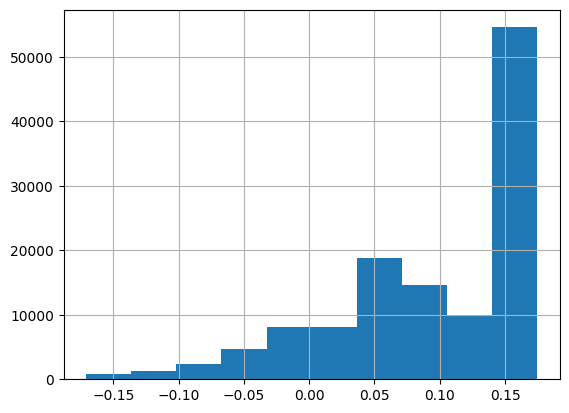

In [31]:
pd.Series(scores).hist()

In [33]:
from sklearn.metrics import accuracy_score
preds = np.where(scores < 0, 0, 1)  # customize threshold
accuracy_score(preds, y_test)

0.8637718005602967

In [35]:
for t in (-2, -.15, -.1, -.05, 0, .05):
    preds = np.where(scores < t, 0, 1)  # customize threshold
    print(t, accuracy_score(preds, y_test))

-2 1.0
-0.15 0.9963726458633588
-0.1 0.9828267452593397
-0.05 0.9523666866387058
0 0.8637718005602967
0.05 0.7370006315482649


In [ ]:
## -0.05 0.816988648325 gives us better than the null accuracy, without ever needing the testing set
# This shows how we can can achieve predictive results without labeled data


# This is an interesting use case of novelty detection becuase generally, when given labels
# we do not use such tactics.